# Import library

In [1]:
# Import library
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load datasets

In [2]:
file_path = '/content/drive/MyDrive/MachineLearningFinal/melb_data_cleaned.xlsx'  # Update path if needed
data = pd.read_excel(file_path)

# Data Preprocessing

In [3]:
# Selecting relevant columns
columns_to_use = [
    'Rooms', 'Type', 'Distance', 'Bedroom2', 'Bathroom', 'Car',
    'Landsize', 'BuildingArea', 'YearBuilt', 'Regionname',
    'Propertycount', 'Method', 'Price'
]
data = data[columns_to_use]

In [4]:
# One-hot encoding for categorical columns
categorical_columns = ['Type', 'Regionname', 'Method']
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

In [5]:
# Scaling numerical columns
scaler = MinMaxScaler()
numerical_columns = [
    'Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car',
    'Landsize', 'BuildingArea', 'YearBuilt', 'Propertycount', 'Price'
]
data_encoded[numerical_columns] = scaler.fit_transform(data_encoded[numerical_columns])

# Splitting into features (X) and target (y)

In [6]:

X = data_encoded.drop(columns=['Price']).values
y = data_encoded['Price'].values

# Reshaping X for LSTM input

In [7]:

X = X.reshape(X.shape[0], 1, X.shape[1])  # (samples, time_steps, features)

# Splitting into training and test sets

In [8]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM Model

In [9]:
model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Compile model

In [10]:

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [11]:
# Early Stopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the Model

In [12]:
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,  # Increased epochs
    batch_size=64,  # Adjusted batch size
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0060 - mae: 0.0550 - val_loss: 0.0022 - val_mae: 0.0296 - learning_rate: 0.0010
Epoch 2/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0020 - mae: 0.0300 - val_loss: 0.0019 - val_mae: 0.0273 - learning_rate: 0.0010
Epoch 3/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018 - mae: 0.0285 - val_loss: 0.0019 - val_mae: 0.0286 - learning_rate: 0.0010
Epoch 4/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0020 - mae: 0.0288 - val_loss: 0.0018 - val_mae: 0.0277 - learning_rate: 0.0010
Epoch 5/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018 - mae: 0.0279 - val_loss: 0.0019 - val_mae: 0.0277 - learning_rate: 0.0010
Epoch 6/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018 - mae: 0.0277 - val_loss: 0.0019 - val_mae: 0.0297 - learning_rate: 0.0010
Epoch 7/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0021 - mae: 0.0285 - val_loss: 0.0018 - val_mae: 0.0282 - learning_rate: 0.0

# Evaluate the Model

In [13]:
y_pred = model.predict(X_test)

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [14]:
# Rescale predictions and actual values to original scale
y_test_rescaled = scaler.inverse_transform([[0] * (len(numerical_columns) - 1) + [val] for val in y_test])[:, -1]
y_pred_rescaled = scaler.inverse_transform([[0] * (len(numerical_columns) - 1) + [val[0]] for val in y_pred])[:, -1]

In [15]:
# Compute Evaluation Metrics
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 124245888852.34024
Mean Absolute Error (MAE): 224569.14521126074
R-squared (R2): 0.6978315455628461


# Visualization

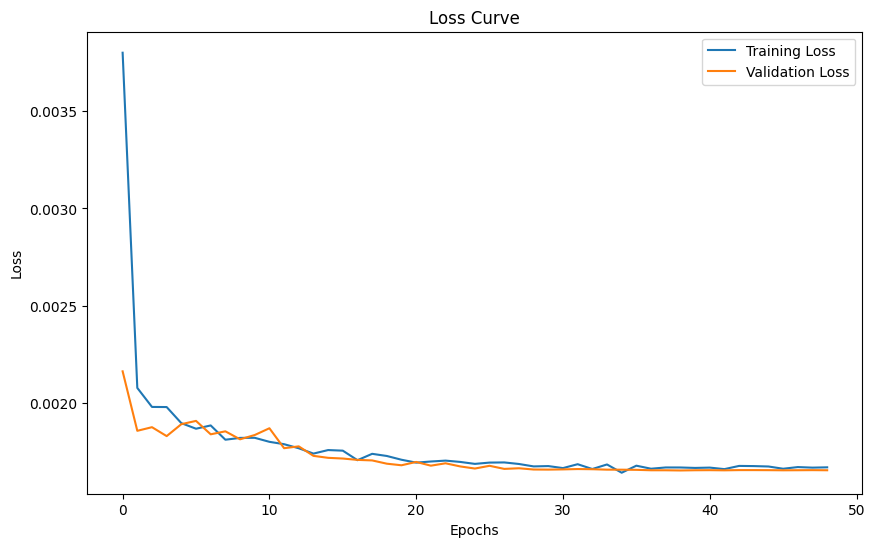

In [16]:
# Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

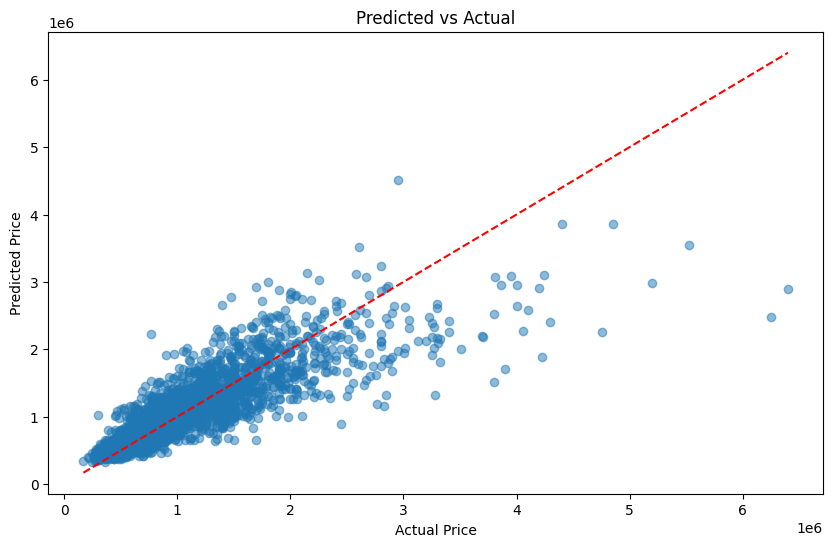

In [17]:
# Predicted vs Actual Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_rescaled, y_pred_rescaled, alpha=0.5)
plt.plot([min(y_test_rescaled), max(y_test_rescaled)], [min(y_test_rescaled), max(y_test_rescaled)], color='red', linestyle='--')
plt.title('Predicted vs Actual')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

# Predict sample

In [18]:
# Ensure all processing and selection is correct without external tools
import numpy as np

# Reshape X_test and y_test to DataFrame and Series for proper manipulation
X_test_df = pd.DataFrame(X_test.reshape(X_test.shape[0], X_test.shape[2]), columns=data_encoded.drop(columns=['Price']).columns)
y_test_df = pd.Series(y_test, name="Actual_Price", index=X_test_df.index)

# Select 5 random samples from test data
sample_data = X_test_df.sample(5, random_state=42)
sample_data['Actual_Price'] = y_test_df.loc[sample_data.index]

# Predict prices for selected houses
predicted_prices = model.predict(sample_data.drop(columns=['Actual_Price']).values.reshape(-1, 1, X_test.shape[2]))

# Add predicted prices to the sample data
sample_data['Predicted_Price'] = predicted_prices

# Rescale prices to original scale
sample_data['Actual_Price'] = scaler.inverse_transform(
    [[0] * (len(numerical_columns) - 1) + [val] for val in sample_data['Actual_Price']]
)[:, -1]
# Rescale predicted prices to the original scale
sample_data['Predicted_Price'] = scaler.inverse_transform(
    [[0] * (len(numerical_columns) - 1) + [val] for val in sample_data['Predicted_Price']]
)[:, -1]


# Display sample data with relevant columns
sample_data_display = sample_data[
    ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car',
     'Landsize', 'BuildingArea', 'YearBuilt', 'Propertycount',
     'Actual_Price', 'Predicted_Price']
]
print(sample_data_display)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
         Rooms  Distance  Bedroom2  Bathroom  Car  Landsize  BuildingArea  \
942   0.333333  0.272349      0.20     0.500  0.4  0.001630      0.000748   
479   0.111111  0.110187      0.10     0.125  0.1  0.005397      0.006839   
2436  0.111111  0.054054      0.10     0.125  0.0  0.000247      0.000332   
1790  0.222222  0.209979      0.15     0.250  0.2  0.001388      0.000831   
755   0.333333  0.245322      0.20     0.250  0.2  0.001716      0.001384   

      YearBuilt  Propertycount  Actual_Price  Predicted_Price  
942    0.888078       0.203542  1.670000e+06     1.816531e+06  
479    0.935523       0.516752  4.500000e+05     6.383526e+05  
2436   0.856448       0.686884  1.035000e+06     1.060287e+06  
1790   0.941606       0.353862  1.570000e+06     1.740243e+06  
755    0.959854       0.197701  1.300000e+06     1.324954e+06  
